In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_bitcoin = pd.read_csv('src/btcusd_1-min_data.csv')
df_ethereum = pd.read_csv('src/ethereum-historical-data.csv')
df_solona = pd.read_csv('src/solana-historical-data.csv')
df_tether = pd.read_csv('src/tether-historical-data.csv')

In [12]:
df_bitcoin['date'] = pd.to_datetime(df_bitcoin.Timestamp, unit='s')

In [15]:
df_bitcoin = df_bitcoin.set_index('date')

In [17]:
df_bitcoin = df_bitcoin.drop(columns=['Timestamp'])

In [45]:
df_bitcoin_days = df_bitcoin.resample('D').mean()

Не усреднять. брать одно значение 

In [49]:
df_bitcoin

,Open,High,Low,Close,Volume
date,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-12-07 23:54:00,90156.00,90200.00,90148.00,90200.00,2.059916
2025-12-07 23:55:00,90200.00,90364.00,90200.00,90352.00,8.852564
2025-12-07 23:56:00,90354.00,90397.00,90319.00,90319.00,1.825611


In [102]:
min_date = df_ethereum['Дата'].min()
max_date = df_ethereum['Дата'].max()

df_bit = df_bitcoin_days[df_bitcoin_days.index >= min_date]
df_bit = df_bit[df_bit.index <= max_date]

In [103]:
df_bit

,Open,High,Low,Close,Volume
date,,,,,
2022-06-09,30262.661833,30270.311653,30254.900729,30262.991250,0.671825
2022-06-10,29790.101896,29800.856799,29778.667104,29790.116444,1.744877
2022-06-11,28952.814104,28961.504937,28943.918542,28953.022347,1.156942
2022-06-12,27821.362389,27832.654076,27808.932882,27820.746389,1.515287
2022-06-13,24931.011736,24963.679653,24897.080792,24930.054437,8.028230
...,...,...,...,...,...
2025-06-05,104031.054167,104055.520139,104006.688194,104032.127778,0.954395
2025-06-06,103705.667361,103725.177083,103689.043056,103708.074306,1.024265
2025-06-07,105264.573611,105274.676389,105255.195139,105264.830556,0.426300


In [58]:
def currency_to_float(column):
    return (column
            .str.replace('$', '', regex=False) # Убираем знак доллара
            .str.replace(',', '', regex=False) # Убираем разделитель тысяч
            .astype(float))

In [87]:
df_eth = df_ethereum[['Дата', 'Закрыть']].copy()

In [88]:
df_eth = df_eth.set_index('Дата')
df_eth = df_eth.sort_index()

In [101]:
df_eth

,Закрыть
Дата,
2022-06-09,1786.0
2022-06-10,1658.0
2022-06-11,1524.0
2022-06-12,1439.0
2022-06-13,1199.0
...,...
2025-06-05,2419.0
2025-06-06,2481.0
2025-06-07,2526.0


In [ ]:
df_eth['Закрыть'] = currency_to_float(df_eth['Закрыть'])

In [95]:
df_bit['close_eth'] = df_eth['Закрыть']

In [146]:
def create_features(df):
    df = df.copy()

    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear

    lags = [1, 2, 3, 7, 14, 28]
    for lag in lags:
        df[f'lag_{lag}'] = df['Close'].shift(lag)

    windows = [7, 14, 28]
    for window in windows:
        df[f'rolling_mean_{window}'] = df.Close.shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df.Close.shift(1).rolling(window=window).std()

    return df

In [141]:
df_features = create_features(df_bit)
df_features = df_features.dropna()

In [151]:
FEATURES = [col for col in df_features.columns if col != 'close']
TARGET = 'Close'

In [152]:
X = df_features[FEATURES]
y = df_features[TARGET]

In [160]:
X = X.drop(columns=['Open', 'High', 'Low'])

In [162]:
val_days = 150
test_days = 50

end_date = df_features.index.max()
test_split_date = end_date - pd.Timedelta(days=test_days)
val_split_date = test_split_date - pd.Timedelta(days=val_days)

X_train = X[X.index < val_split_date]
y_train = y[y.index < val_split_date]

mask_val = (X.index >= val_split_date) & (X.index < test_split_date)
X_val = X[mask_val]
y_val = y[mask_val]

X_test = X[X.index >= test_split_date]
y_test = y[y.index >= test_split_date]

In [125]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Text(0.5, 1.0, 'Разбиение данных')

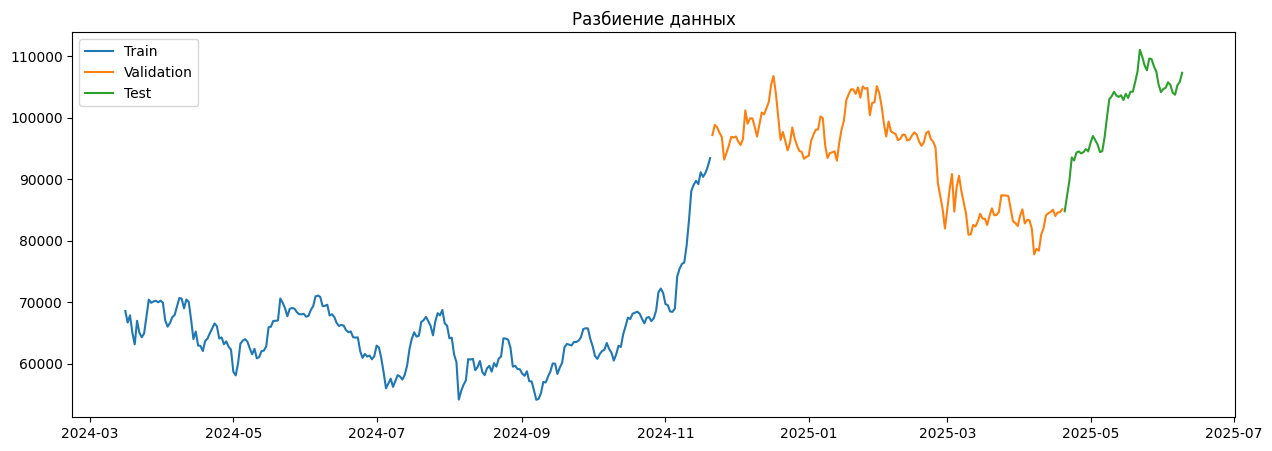

In [135]:
plt.figure(figsize=(15, 5))
plt.plot(y_train.index[-250:], y_train[-250:], label='Train')
plt.plot(y_val.index, y_val, label='Validation')
plt.plot(y_test.index, y_test, label='Test')
plt.legend()
plt.title('Разбиение данных')

In [163]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50, 
    objective='reg:squarederror'
)

In [164]:

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

[0]	validation_0-rmse:18975.00441	validation_1-rmse:54204.86164
[100]	validation_0-rmse:7121.00761	validation_1-rmse:29879.59244
[200]	validation_0-rmse:2687.11707	validation_1-rmse:20389.45717
[300]	validation_0-rmse:1026.89467	validation_1-rmse:15988.55203
[400]	validation_0-rmse:406.13539	validation_1-rmse:14245.88392
[500]	validation_0-rmse:175.97153	validation_1-rmse:13510.36469
[600]	validation_0-rmse:93.52707	validation_1-rmse:13270.87421
[700]	validation_0-rmse:63.48420	validation_1-rmse:13130.20981
[800]	validation_0-rmse:51.84496	validation_1-rmse:13064.49146
[900]	validation_0-rmse:46.05113	validation_1-rmse:13030.20050
[999]	validation_0-rmse:42.44972	validation_1-rmse:13011.88567


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [165]:
prediction = reg.predict(X_test)

result = pd.DataFrame({'prediction_close': prediction}, index=y_test.index)

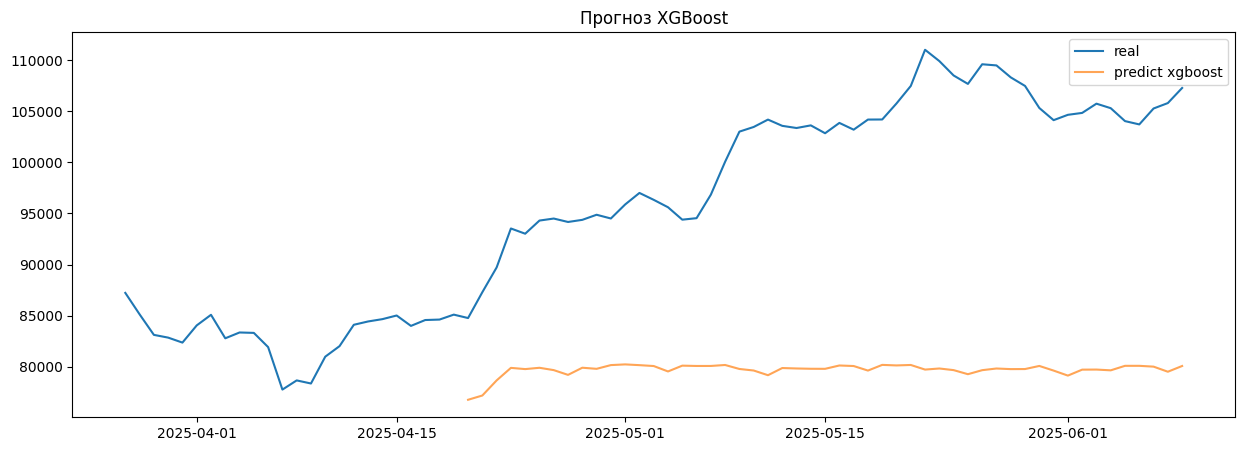

In [166]:
plt.figure(figsize=(15, 5))
plt.plot(df_bit.index[-75:], df_bit.Close[-75:], label='real')
plt.plot(result.index, result.prediction_close, label='predict xgboost', alpha=0.7)
plt.title('Прогноз XGBoost')
plt.legend()

In [167]:
df_target = X
data = pd.DataFrame(df_target.Close)

In [170]:
data['log_ret'] = np.log(data.Close / data.Close.shift(1))

In [171]:
def compute_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [174]:
data['sma_14'] = data['Close'].rolling(window=14).mean()
data['sma_30'] = data['Close'].rolling(window=30).mean()

data['dist_sma_14'] = data['Close'] / data['sma_14'] - 1
data['dist_sma_30'] = data['Close'] / data['sma_30'] - 1

data['rsi_14'] = compute_rsi(data['Close'], 14)

lags = [1, 2, 3, 5, 10, 20]
for lag in lags:
    data[f'lag_ret_{lag}'] = data['log_ret'].shift(lag)

data['volatility_7'] = data['log_ret'].rolling(window=7).std()

data.dropna(inplace=True)

In [188]:
X_l

,Close,dist_sma_14,dist_sma_30,rsi_14,lag_ret_1,lag_ret_2,lag_ret_3,lag_ret_5,lag_ret_10,lag_ret_20,volatility_7
date,,,,,,,,,,,
2022-08-05,22983.184410,0.005341,0.041751,48.170444,-0.009160,0.007727,-0.013926,-0.012036,-0.042418,0.005273,0.010824
2022-08-06,23192.480625,0.012533,0.047105,55.161228,0.001302,-0.009160,0.007727,-0.019664,0.008940,0.020289,0.011259
2022-08-07,23068.032028,0.005602,0.039382,53.903706,0.009065,0.001302,-0.009160,-0.013926,0.079152,0.020426,0.010864
2022-08-08,23695.915375,0.027854,0.064399,62.791318,-0.005380,0.009065,0.001302,0.007727,0.032523,0.025507,0.013740
2022-08-09,23557.251444,0.014363,0.054540,71.728510,0.026855,-0.005380,0.009065,-0.009160,0.006908,0.057916,0.012423
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,104032.127778,-0.025719,-0.010935,25.166632,-0.004189,0.008588,0.001781,-0.011376,0.017686,0.009775,0.010443
2025-06-06,103708.074306,-0.024712,-0.016158,26.649240,-0.012068,-0.004189,0.008588,0.005008,-0.001033,-0.006389,0.007859
2025-06-07,105264.830556,-0.007920,-0.003032,37.962417,-0.003120,-0.012068,-0.004189,0.001781,-0.010744,0.009535,0.008944


In [175]:
features = [col for col in data.columns if col not in ['close', 'log_ret', 'sma_14', 'sma_30']]
target = 'log_ret'

X_l = data[features]
y_l = data[target]

In [176]:
end_date_l = data.index.max()
test_split_date_l = end_date_l - pd.Timedelta(days=test_days)
val_split_date_l = test_split_date_l - pd.Timedelta(days=val_days)

X_train_l = X_l[X_l.index < val_split_date_l]
y_train_l = y_l[y_l.index < val_split_date_l]

mask_val_l = (X_l.index >= val_split_date_l) & (X_l.index < test_split_date_l)
X_val_l = X_l[mask_val_l]
y_val_l = y_l[mask_val_l]

X_test_l = X_l[X_l.index >= test_split_date_l]
y_test_l = y_l[y_l.index >= test_split_date_l]

In [177]:
reg_l = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.001,
    max_depth=4,
    subsample=0.7,         
    colsample_bytree=0.7,  
    objective='reg:squarederror'
)

In [178]:
reg_l.fit(
    X_train_l, y_train_l,
    eval_set=[(X_train_l, y_train_l), (X_val_l, y_val_l)],
    verbose=100)

[0]	validation_0-rmse:0.02140	validation_1-rmse:0.02028
[100]	validation_0-rmse:0.02083	validation_1-rmse:0.01997
[200]	validation_0-rmse:0.02030	validation_1-rmse:0.01968
[300]	validation_0-rmse:0.01983	validation_1-rmse:0.01943
[400]	validation_0-rmse:0.01939	validation_1-rmse:0.01919
[500]	validation_0-rmse:0.01897	validation_1-rmse:0.01898
[600]	validation_0-rmse:0.01860	validation_1-rmse:0.01881
[700]	validation_0-rmse:0.01823	validation_1-rmse:0.01862
[800]	validation_0-rmse:0.01790	validation_1-rmse:0.01846
[900]	validation_0-rmse:0.01760	validation_1-rmse:0.01833
[999]	validation_0-rmse:0.01731	validation_1-rmse:0.01819


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [182]:
pred_log_ret = reg_l.predict(X_test_l)

In [184]:
prev_close_for_test = data['Close'].shift(1).loc[y_test_l.index]
pred_price = prev_close_for_test * np.exp(pred_log_ret)

real_price = data.loc[y_test_l.index, 'Close']

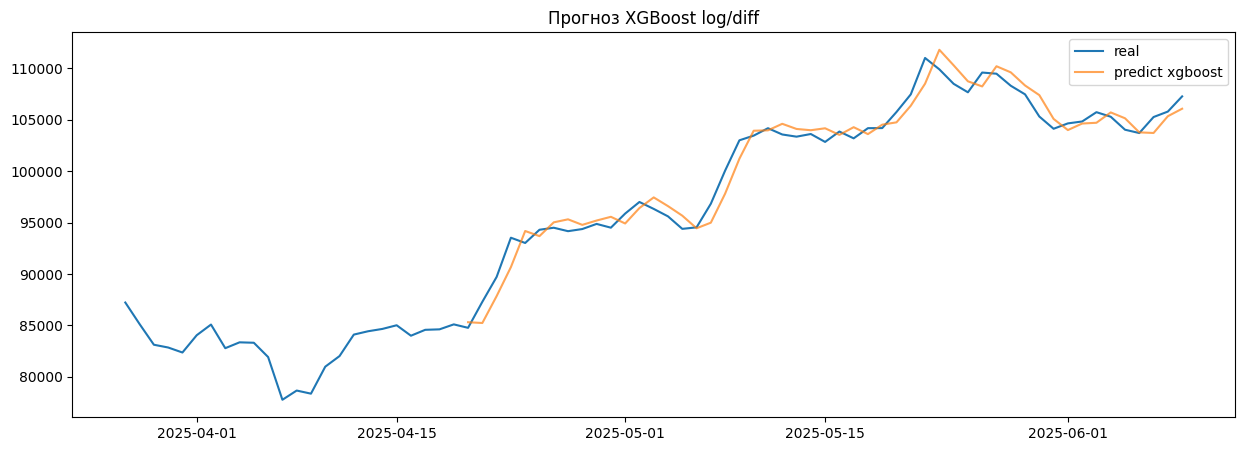

In [187]:
plt.figure(figsize=(15, 5))
plt.plot(df_features.index[-75:], df_features.Close[-75:], label='real')
plt.plot(pred_price.index, pred_price, label='predict xgboost', alpha=0.7)
plt.title('Прогноз XGBoost log/diff')
plt.legend()